# DnD 5e Monsters
## A Personal Data Science Project

My starting point was the Kaggle data set at https://www.kaggle.com/datasets/mrpantherson/dnd-5e-monsters which appears to be mostly taken from a French DnD site. A lot of the ability stats were missing, but I found basically everything I needed to fill them in from https://www.dndwiki.io/monsters. I did not add monsters or characters that were not already in the original Kaggle set, but I did change a few other details in Excel before getting started here, like:
- converting the "legendary" column to binary numerical values,
- updating the values for legendary creatures not previously marked as such, 
- renaming "speed" as "movement" since non-standard modes of movement were given rather than distances moved per turn, 
- deleting the superfluous URL column, and
- adding a binary numeric "unique" column to distinguish individual characters from species.

Another time I might go back and figure out how to scrape the DnD wiki for stats (if legal; nothing came up when I checked if there was a /robots.txt extension), but at the time it was quicker for me to just fill the stats by hand. It also looks like the DnD wiki site entered the stats in the HTML templates by hand on their end, rather than inserting values from a database. That would mean having to open and scrape each link individually, which could be done with a for loop and some regular expressions, but I could see that landing me in trouble for bandwidth usage or rapid link switching alone. Not something I wanna risk while I'm an expat.

Anyway, I wanted to do this to practice feature engineering and ML stuff, so here goes nothing.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sb #I still don't know why the ML course used sns as the abbr for this package

In [55]:
df = pd.read_csv('dnd_monsters_v1.csv', header=0, index_col=0)
df.head()

,cr,type,size,ac,hp,movement,align,legendary,source,str,dex,con,int,wis,cha,unique
name,,,,,,,,,,,,,,,,
aarakocra,0.25,humanoid (aarakocra),Medium,12,13,fly,neutral good,0,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0,0.0
abjurer,9.00,humanoid (any race),Medium,12,84,NaN,any alignment,0,Volo's Guide to Monsters,9.0,14.0,14.0,12.0,18.0,11.0,0.0
aboleth,10.00,aberration,Large,17,135,swim,lawful evil,1,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0,0.0
abominable-yeti,9.00,monstrosity,Huge,15,137,NaN,chaotic evil,0,Monster Manual,24.0,10.0,22.0,9.0,13.0,9.0,0.0
acererak,23.00,undead,Medium,21,285,NaN,neutral evil,0,Adventures (Tomb of Annihilation),13.0,16.0,20.0,27.0,21.0,20.0,1.0


It bugs me that movement is NaN unless the creature can also swim or fly, and I can't just sub in the default because most of the creatures with "swim" and/or "fly" can also move the standard way. I'm going to get dummy variables from that column and then get rid of it.

Also just learned that df.apply() has issues dealing with nans and lambda expressions simultaneously.

In [56]:
df['movement'].replace(np.nan,'ground',inplace=True)
df['movement'].unique()

array(['fly', 'ground', 'swim', 'fly, swim'], dtype=object)

In [57]:
df['can_fly']=df['movement'].apply(lambda s: int('fly' in s))

In [58]:
df['can_swim']=df['movement'].apply(lambda s: int('swim' in s))

In [59]:
df.drop(columns=['movement'],inplace=True)
df.head()

,cr,type,size,ac,hp,align,legendary,source,str,dex,con,int,wis,cha,unique,can_fly,can_swim
name,,,,,,,,,,,,,,,,,
aarakocra,0.25,humanoid (aarakocra),Medium,12,13,neutral good,0,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0,0.0,1,0
abjurer,9.00,humanoid (any race),Medium,12,84,any alignment,0,Volo's Guide to Monsters,9.0,14.0,14.0,12.0,18.0,11.0,0.0,0,0
aboleth,10.00,aberration,Large,17,135,lawful evil,1,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0,0.0,0,1
abominable-yeti,9.00,monstrosity,Huge,15,137,chaotic evil,0,Monster Manual,24.0,10.0,22.0,9.0,13.0,9.0,0.0,0,0
acererak,23.00,undead,Medium,21,285,neutral evil,0,Adventures (Tomb of Annihilation),13.0,16.0,20.0,27.0,21.0,20.0,1.0,0,0


Next up is that type section. There are 14 Types of monsters that are somewhat informative of their origins, but there are parentheticals that are complicating that column alone and would be more useful separately (e.g. there are playable and non-playable humanoids and the terms in parentheses can help pick out the playable ones). In the MM, they're called tags, and for lack of a better term, I'll stick with that.

In [60]:
mtype = df['type'].apply(lambda s: s.split(' ')[0])

In [61]:
df.loc['abjurer','type'].split(maxsplit=1)[1].replace('(','').replace(')','')

'any race'

In [62]:
def get_tags(s):
    t = s.split(maxsplit = 1)
    if len(t)==1:
        return None
    else:
        return t[1].replace('(','').replace(')','')

In [63]:
tags = df['type'].apply(get_tags)

In [64]:
tags

name
aarakocra            aarakocra
abjurer               any race
aboleth                   None
abominable-yeti           None
acererak                  None
                       ...    
yuan-ti-pureblood      yuan-ti
zaratan                   None
zariel                   devil
zombie                    None
zuggtmoy                 demon
Name: type, Length: 767, dtype: object

In [65]:
df['type']=mtype

In [66]:
df.insert(2,'tag',tags)

In [67]:
df.head()

,cr,type,tag,size,ac,hp,align,legendary,source,str,dex,con,int,wis,cha,unique,can_fly,can_swim
name,,,,,,,,,,,,,,,,,,
aarakocra,0.25,humanoid,aarakocra,Medium,12,13,neutral good,0,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0,0.0,1,0
abjurer,9.00,humanoid,any race,Medium,12,84,any alignment,0,Volo's Guide to Monsters,9.0,14.0,14.0,12.0,18.0,11.0,0.0,0,0
aboleth,10.00,aberration,None,Large,17,135,lawful evil,1,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0,0.0,0,1
abominable-yeti,9.00,monstrosity,None,Huge,15,137,chaotic evil,0,Monster Manual,24.0,10.0,22.0,9.0,13.0,9.0,0.0,0,0
acererak,23.00,undead,None,Medium,21,285,neutral evil,0,Adventures (Tomb of Annihilation),13.0,16.0,20.0,27.0,21.0,20.0,1.0,0,0


In [16]:
df[80:85]

,cr,type,tag,size,ac,hp,align,legendary,source,str,dex,con,int,wis,cha,unique,can_fly,can_swim
name,,,,,,,,,,,,,,,,,,
behir,11.0,monstrosity,None,Huge,17,168,neutral evil,0,Monster Manual (SRD),23.0,16.0,18.0,7.0,14.0,12.0,0.0,0,0
beholder,13.0,aberration,None,Large,18,180,lawful evil,1,Monster Manual,10.0,14.0,18.0,17.0,15.0,17.0,0.0,1,0
beholder-zombie,5.0,undead,None,Large,15,93,neutral evil,0,Monster Manual,10.0,8.0,16.0,3.0,8.0,5.0,0.0,1,0
bel,25.0,fiend,devil,Large,19,364,lawful evil,1,Monster Manual,28.0,14.0,26.0,25.0,19.0,26.0,1.0,1,0
belaphoss,20.0,fiend,demon,Huge,19,262,chaotic evil,0,Extra (Dragon Mag),26.0,15.0,22.0,20.0,16.0,22.0,1.0,1,0


Note to self: the 0-indexed integer location of the inserted column counts rightward from the first column AFTER, EXCLUDING, the column of index labels.

In [17]:
df['size'] = df['size'].str.lower()

In [18]:
df[120:125]

,cr,type,tag,size,ac,hp,align,legendary,source,str,dex,con,int,wis,cha,unique,can_fly,can_swim
name,,,,,,,,,,,,,,,,,,
catoblepas,5.0,monstrosity,None,large,14,84,unaligned,0,Volo's Guide to Monsters,19.0,12.0,21.0,3.0,14.0,8.0,0.0,0,0
cave-fisher,3.0,monstrosity,None,medium,16,58,unaligned,0,Volo's Guide to Monsters,16.0,13.0,14.0,3.0,10.0,3.0,0.0,0,0
centaur,2.0,monstrosity,None,large,12,45,neutral good,0,Monster Manual (SRD),18.0,14.0,14.0,9.0,13.0,11.0,0.0,0,0
chain-devil,8.0,fiend,devil,medium,16,85,lawful evil,0,Monster Manual (SRD),18.0,15.0,18.0,11.0,12.0,14.0,0.0,0,0
champion,9.0,humanoid,any race,medium,18,143,any alignment,0,Volo's Guide to Monsters,20.0,15.0,14.0,10.0,14.0,12.0,0.0,0,0


In [68]:
df['tag'].value_counts()

any race                 68
demon                    35
devil                    27
elf                      18
human                    15
shapechanger             11
yugoloth                 10
goblinoid                10
dwarf                     9
orc                       9
gith                      9
of Tiny beasts            8
gnoll                     6
shapechanger, yuan-ti     6
kobold                    5
human, shapechanger       5
sorrowsworn               5
titan                     5
illithid                  4
lizardfolk                3
demon, shapechanger       3
sahuagin                  3
grung                     3
kuo-toa                   3
tabaxi                    2
tortle                    2
xvart                     2
yuan-ti                   2
gnome                     2
derro                     2
firenewt                  2
inevitable                1
meazel                    1
cloud giant               1
troglodyte                1
saurial             

In [69]:
df['type'].value_counts()

humanoid       191
beast          106
fiend           90
monstrosity     86
undead          50
dragon          48
aberration      38
elemental       38
giant           27
construct       24
plant           24
fey             21
ooze             8
celestial        8
swarm            8
Name: type, dtype: int64

This is another thing that bothers me. Sometimes the tag isn't what's expected; rather, the tag column seems to be doing several jobs at once. For instance, there are at least 5 types of Slaadi, but the tag just says "shapechanger", while several other tags only appear once, and others have 2 tags. First, let's fix the issue of types and tags with swarms, since they're kind of unique.

In [70]:
df['type'].replace({'swarm':'beast'},inplace=True)

In [71]:
df['tag'].replace({'of Tiny beasts':'swarm'},inplace=True)

"Shapechanger" seems to be more of an ability metric than biological characterization, so lets move that to a column.

In [72]:
df['shapechanger']=df['tag'].apply(lambda s: int('shapechanger' in s if s is not None else False))

In [73]:
df.loc['green-slaad']

cr                          8.0
type                 aberration
tag                shapechanger
size                      Large
ac                           16
hp                          127
align           chaotic neutral
legendary                     0
source           Monster Manual
str                        18.0
dex                        15.0
con                        16.0
int                        11.0
wis                         8.0
cha                        12.0
unique                      0.0
can_fly                       0
can_swim                      0
shapechanger                  1
Name: green-slaad, dtype: object

In [74]:
df['tag']=df['tag'].apply(lambda s: s.replace('shapechanger','').replace(', ','') if s is not None else None)

In [75]:
df['tag'].replace({'':None},inplace=True)

In [76]:
df.loc[df['tag'].loc[df.index.str.contains('slaad')].index,'tag'] = 'slaad'

Here I added "slaad" to the tags of slaadi. It looks like you should be able to set this with only the text between the first .loc and .index, but that only returns a view. The stuff around it is required to set the value in place.

In [77]:
junktags=list(df.tag.value_counts().loc[lambda x: x<=2].index)

In [78]:
junktags

['gnome',
 'tabaxi',
 'firenewt',
 'derro',
 'tortle',
 'xvart',
 'thri-kreen',
 'demonorc',
 'troglodyte',
 'cloud giant',
 'storm giant',
 'stone giant',
 'nagpa',
 'quaggoth',
 'fire giant',
 'hill giant',
 'merfolk',
 'meazel',
 'inevitable',
 'kenku',
 'grimlock',
 'saurial',
 'frost giant',
 'aarakocra']

The above are tags that appear only once or twice. Some of them are associated with other monsters that aren't tagged as such but have the tag as their name, and those I will propagate to the tags. The rest I'll eliminate.

In [79]:
#Full disclosure, a lot of these I looked at in the file itself rather than here.
for t in ['storm-giant','cloud-giant','fire-giant','stone-giant','hill-giant','frost-giant','-neogi','star-spawn']:
    df.loc[df['tag'].loc[df.index.str.contains(t)].index,'tag'] = t.replace('-','') if t=='-neogi' else t.replace('-',' ')

In [80]:
df['tag'].value_counts()

any race       68
demon          38
devil          28
human          20
elf            18
yugoloth       10
goblinoid      10
gith            9
dwarf           9
orc             9
swarm           8
yuan-ti         8
gnoll           6
slaad           6
star spawn      5
titan           5
sorrowsworn     5
kobold          5
illithid        4
kuo-toa         3
lizardfolk      3
sahuagin        3
grung           3
stone giant     2
tabaxi          2
tortle          2
gnome           2
derro           2
hill giant      2
cloud giant     2
frost giant     2
firenewt        2
fire giant      2
xvart           2
storm giant     2
thri-kreen      1
troglodyte      1
demonorc        1
aarakocra       1
quaggoth        1
nagpa           1
merfolk         1
meazel          1
inevitable      1
grimlock        1
saurial         1
kenku           1
Name: tag, dtype: int64

In [81]:
junktags=list(df.tag.value_counts().loc[lambda x: x<2].index)
print(junktags)

['thri-kreen', 'troglodyte', 'demonorc', 'aarakocra', 'quaggoth', 'nagpa', 'merfolk', 'meazel', 'inevitable', 'grimlock', 'saurial', 'kenku']


In [82]:
df['tag'].replace(junktags,None,inplace=True)

In [83]:
df.head()

,cr,type,tag,size,ac,hp,align,legendary,source,str,dex,con,int,wis,cha,unique,can_fly,can_swim,shapechanger
name,,,,,,,,,,,,,,,,,,,
aarakocra,0.25,humanoid,None,Medium,12,13,neutral good,0,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0,0.0,1,0,0
abjurer,9.00,humanoid,any race,Medium,12,84,any alignment,0,Volo's Guide to Monsters,9.0,14.0,14.0,12.0,18.0,11.0,0.0,0,0,0
aboleth,10.00,aberration,None,Large,17,135,lawful evil,1,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0,0.0,0,1,0
abominable-yeti,9.00,monstrosity,None,Huge,15,137,chaotic evil,0,Monster Manual,24.0,10.0,22.0,9.0,13.0,9.0,0.0,0,0,0
acererak,23.00,undead,None,Medium,21,285,neutral evil,0,Adventures (Tomb of Annihilation),13.0,16.0,20.0,27.0,21.0,20.0,1.0,0,0,0


I just discovered the abominable yeti and the yeti should be tagged as related. For that matter, so should different age groups of the same species of dragon.

In [84]:
df.loc[df['tag'].loc[df.index.str.contains('yeti')].index,'tag'] = 'yeti'
dc = ['white','black','red','green','blue','gold','silver','brass','bronze','copper']
for td in dc:
    df.loc[df['tag'].loc[df.index.str.contains('{}-dragon'.format(td))].index,'tag'] = '{} dragon'.format(td)

In [85]:
df['tag'].value_counts()

any race         68
demon            38
devil            28
human            19
elf              18
goblinoid        10
yugoloth         10
dwarf             9
orc               9
gith              9
swarm             8
yuan-ti           8
slaad             6
gnoll             6
kobold            5
star spawn        5
red dragon        5
titan             5
sorrowsworn       5
silver dragon     4
brass dragon      4
illithid          4
blue dragon       4
white dragon      4
bronze dragon     4
copper dragon     4
gold dragon       4
green dragon      4
black dragon      4
sahuagin          3
kuo-toa           3
lizardfolk        3
grung             3
hill giant        2
frost giant       2
firenewt          2
fire giant        2
yeti              2
stone giant       2
storm giant       2
gnome             2
tabaxi            2
cloud giant       2
tortle            2
xvart             2
derro             2
Name: tag, dtype: int64

In [37]:
df.loc['death-tyrant']

cr                        14.0
type                    undead
tag                       None
size                     large
ac                          19
hp                         187
align              lawful evil
legendary                    1
source          Monster Manual
str                       10.0
dex                       14.0
con                       14.0
int                       19.0
wis                       15.0
cha                       19.0
unique                     0.0
can_fly                      1
can_swim                     0
shapechanger                 0
Name: death-tyrant, dtype: object

There's still some more work I want to do with tags. I know there are several types of beholder kin (gazers, spectators, death kisses, etc), several types of zombie and lich... Well, the undead types tend to be templates on other types, so let's leave those alone.

In [86]:
for t in ['gazer','gauth','spectator','death-kiss']:
    df.loc[df['tag'].loc[df.index.str.contains(t)].index,'tag'] = 'beholderkin'

In [87]:
for t in ['beholder','death-tyrant']:
    df.loc[df['tag'].loc[df.index.str.contains(t)].index,'tag'] = 'beholder'

In [88]:
df.index[df.index.str.contains('zombie')].values

array(['beholder-zombie', 'ogre-zombie', 'yellow-musk-zombie', 'zombie'],
      dtype=object)

In [89]:
df.loc['ogre-zombie','tag']='giant'

In [90]:
df['source'].value_counts()

Monster Manual (SRD)                      326
Mordenkainen's Tome of Foes               133
Volo's Guide to Monsters                  117
Monster Manual                             69
Monster Manual (BR)                        37
Essentials Kit                             24
Adventures (Tomb of Annihilation)          23
Adventures (Descent into Avernus)          11
Extra (AideDD)                              5
Adventures (Storm King's Thunder)           4
Adventures (Princes of the Apocalypse)      4
Adventures (Dragon Heist)                   4
Adventures (Tyranny of Dragons)             3
Extra (Adventurers League)                  3
Extra (Dragon Mag)                          1
Adventures (Dungeon of the Mad Mage)        1
5e Advanced Mode                            1
Adventures (Curse of Strahd)                1
Name: source, dtype: int64

One thing I wanted to look at was whether there was a difference in the way hp, ac, or cr shake out from different sources. I think several of these source tags could stand to be combined: different versions of the MM, for instance (I have my own copy of the 5e MM, and have seen that monsters within could have any or none of the parentheticals in this list and still have the same stats). MToF and VGtM can stay separate since they're specific editions (one of them---I believe VGtM---is currently listed as legacy material for some reason, so it'll be interesting to see if there are any population differences between the material in the legacy book and the other distributions). The various Adventures are all but WotC content scattered across time, and  the rest (particularly those with Extra in the name) contain material that dates to before the split with Paizo.

The essentials kit includes playable classes for which only the first level has stats recorded, so I'll probably drop entries containing those, along with the entries for individual characters since individual creatures don't offer much of anything in the way of population-level info.

In [91]:
df.loc['tarrasque','unique']=0

In [92]:
df.drop(df[df['unique']==1].index,inplace=True)

In [93]:
len(df.index[df.index.str.contains('lvl')].values)

24

In [94]:
#that number tells me all the rows in the essentials kit are characters with different levels. I don't want those.
df.drop(df[df.index.str.contains('lvl')].index,inplace=True)

In [95]:
df.drop('unique',axis=1,inplace=True)

In [96]:
df['source'].replace(['Monster Manual (SRD)','Monster Manual (BR)'],'Monster Manual',inplace=True)
df['source'].replace( df['source'].value_counts().loc[lambda x: x<=100].index.values, 'Other',inplace=True)

In [97]:
df['source'].value_counts()

Monster Manual                 431
Mordenkainen's Tome of Foes    119
Volo's Guide to Monsters       117
Other                           46
Name: source, dtype: int64

OK, *now* we can start looking at pairplots and stuff.

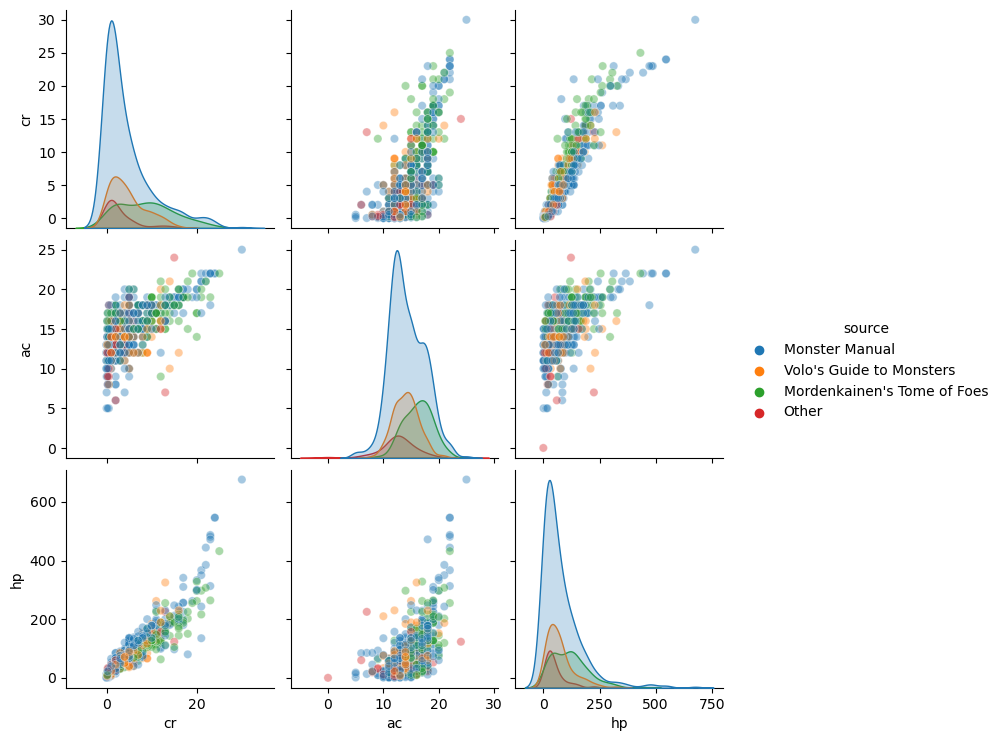

In [98]:
sb.pairplot(df,hue='source',vars=['cr','ac','hp'],plot_kws={'alpha':0.4})

Now that's interesting: the monsters of VGtM seem to be systematically weaker than the ones in MToF, and in terms of challenge ratings, the monsters of MToF are the only ones whose distribution does not mirror a scaled version of the kinda-sorta log-normal distribution seen for the MM. That probably makes sense if the focus of MToF is more on monsters that the titular character would actually consider a threat.

But of course, these are still small-number statistics, so take with a grain of salt.

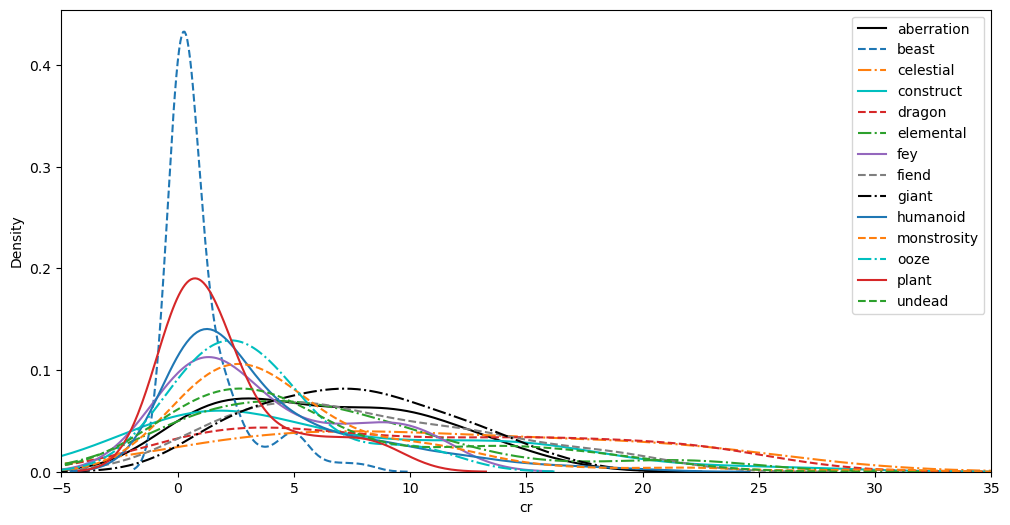

In [99]:
from itertools import cycle
ls = ['-','--','-.']
lc = ['k','tab:blue','tab:orange','c','tab:red','tab:green','tab:purple','tab:gray']
linecycler = cycle(ls)
clrcycler=cycle(lc)
plt.figure(figsize=[12,6])
for t in sorted(df['type'].unique()):
    ax = sb.kdeplot(df[df['type']==t],x='cr',ls=next(linecycler),color=next(clrcycler),label=t,common_norm=False)
plt.xlim(-5,35)
plt.legend()

Plotly and Cufflinks aren't installed for this env, so let me split this into a couple different plots. Beasts, Fey, plants, and Oozes are clustered at the low end, so I'll group them together, along with humanoids and Giants, who have relatively low maximal CRs (20 and 16, respectively). The rest have fairly broad distributions, with Celestials, Dragons, Elementals, Fiends, and a few Undead skewing especially high.

In [100]:
for t in sorted(df['type'].unique()):
    print(t, max(df[df['type']==t]['cr']))

aberration 16.0
beast 8.0
celestial 23.0
construct 25.0
dragon 24.0
elemental 23.0
fey 10.0
fiend 21.0
giant 16.0
humanoid 20.0
monstrosity 30.0
ooze 10.0
plant 9.0
undead 21.0


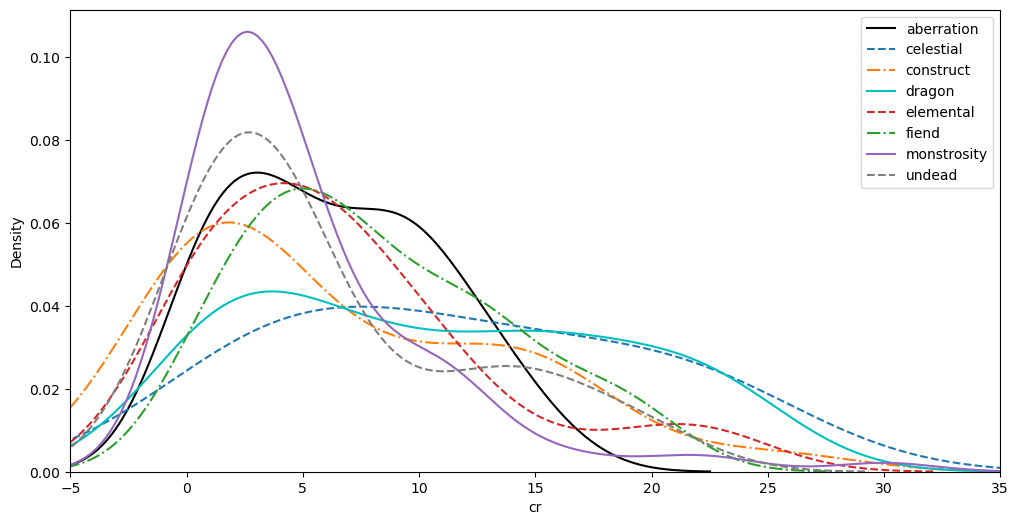

In [101]:
ls = ['-','--','-.']
lc = ['k','tab:blue','tab:orange','c','tab:red','tab:green','tab:purple','tab:gray']
linecycler = cycle(ls)
clrcycler=cycle(lc)
plt.figure(figsize=[12,6])
for t in sorted(df['type'].unique()):
    if t not in ['beast','plant','ooze','fey','giant','humanoid']:
        ax = sb.kdeplot(df[df['type']==t],x='cr',ls=next(linecycler),color=next(clrcycler),label=t,common_norm=False)
plt.xlim(-5,35)
plt.legend()

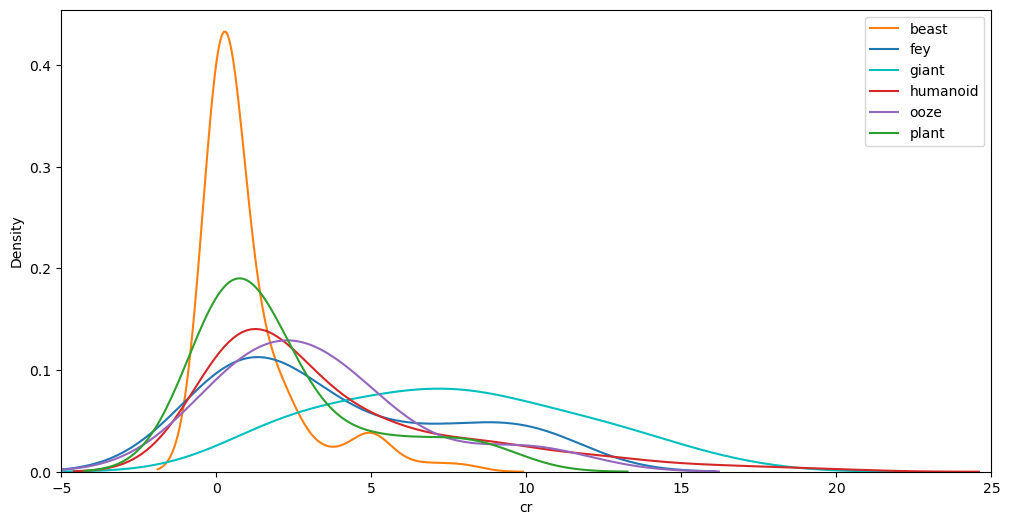

In [102]:
#ls = ['-','--','-.']
lc = ['tab:orange','tab:blue','c','tab:red','tab:purple','tab:green']
linecycler = cycle(ls)
clrcycler=cycle(lc)
plt.figure(figsize=[12,6])
for t in sorted(df['type'].unique()):
    if t in ['beast','plant','ooze','fey','giant','humanoid']:
        ax = sb.kdeplot(df[df['type']==t],x='cr',color=next(clrcycler),label=t,common_norm=False)
plt.xlim(-5,25)
plt.legend()

In [103]:
'tarrasque' in df.index

True

So I can pick this up later without having to redo everything...

In [104]:
df.to_csv('dnd_monsters_v2.csv',index=True)

In [106]:
#df.to_excel('dnd_monsters_v2.xlsx',index=True,sheet_name='basic_stats')
# ^When I run this I get this error: ModuleNotFoundError: No module named 'openpyxl'; 
#  need to install this, Cufflinks, & Plotly in tflow env